# Solution: Influenza outbreak in a school

**1) Use your calibration skills to fit an SIR model to the outbreak data before the intervention was introduced (up until day 17), using the maximum-likelihood approach.**

Loading the data and saving the subset that will be used for the calibration:

In [1]:
# Read in the dataset
flu_data <- read.csv("../GraphicsAndData/w8_nb3_flu_data.csv")

# Explore the dataset format
head(flu_data)  # prints the first few rows of the dataset including the column names


day,cases
0,0
1,1
2,1
3,0
4,2
5,5


We'll rename the two columns for use with our existing ```SIR_loglik()``` function:

In [2]:
# Rename
colnames(flu_data)[1] <- "time"
colnames(flu_data)[2] <- "number_reported"

# Check the new names
head(flu_data)

time,number_reported
0,0
1,1
2,1
3,0
4,2
5,5


And copy some data into a separate variable, to calibrate with:

In [3]:
# Save a subset of the dataset for use in the calibration: days 0-17 (before the school was closed)
calibration_data <- flu_data[flu_data$time < 18,]

Defining the model input, SIR model function and distance function calculating the log-likelihood:

In [4]:
# Load packages
require(deSolve)
require(reshape2)
require(ggplot2)

# Set up initial model state and times vector
initial_state_values <- c(S = 455,  # of the 456 students in the school, all but the one infected case are susceptible
                          I = 1,    # the outbreak starts with one infected case
                          R = 0)    # there is no previous immunity to the pandemic influenza strain in the population

times <- seq(from = 0, to = 17, by = 1)  # the calibration dataset spans days 0-17, so we simulate the model for this time

# Define the Susceptible-Infected-Recovered model
SIR_model <- function(time, state, parameters) {  
  
  with(as.list(c(state, parameters)), {
    
    N <- S+I+R
    
    lambda <- beta * I/N
    
    # The differential equations
    dS <- -lambda * S               
    dI <- lambda * S - gamma * I
    dR <- gamma * I             
    
    # Output
    return(list(c(dS, dI, dR))) 
  })
}


# Define a function to calculate the distance between between the SIR model output
# and observed epidemiological data, using log-likelihood.
# As our flu dataset refers to reported cases, we need to make a corresponding adjustment to the model output.
# In case we'd like to use this function with other datasets (which may have a different reporting rate), we'll pass
# this value as a function argument.
# Arguments:
#    'parameters': must contain beta and gamma model parameters
#    'reported_data': will be the data to compare with. Note we have sometimes called this 'dat' instead.
#    'reporting_rate': refers to the proportion of actual cases which are reported, expressed as a fraction
SIR_loglik <- function(parameters, reported_data, reporting_rate) {   # takes as inputs the parameter values and dataset
  
   beta <- parameters[1]    # extract and save the first value in the "parameters" input argument as beta
   gamma <- parameters[2]   # extract and save the second value in the "parameters" input argument as gamma
    
   # Simulate the model with initial conditions and timesteps defined above, and parameter values from function call
   output <- as.data.frame(ode(y = initial_state_values, 
                               times = times, 
                               func = SIR_model,
                               parms = c(beta = beta,       # ode() takes the values for beta and gamma extracted from
                                         gamma = gamma)))   # the "parameters" input argument of the SIR_loglik() function

   # Ensure we're working with equivalent time points by selecting elements
   # where output$time is in reported_data$time
   matched_results <- output$I[output$time %in% reported_data$time]

   # Calculate log-likelihood, accounting for the reporting rate by reducing cases in the model output accordingly.
   # Note that lambda here has to do with the shape of the Poisson distribution, and is nothing to do with lambda 
   # in the epidemiological sense.
   LL <- sum(dpois(x = reported_data$number_reported, lambda = reporting_rate * matched_results, log = TRUE))
    
   return(LL) 
}

Loading required package: deSolve
Loading required package: reshape2
Loading required package: ggplot2


Optimising the SIR_loglik() function to estimate $\beta$ and $\gamma$ by maximising the likelihood:

In [5]:
# Run optimisation
optim(par = c(0.5, 0.5),                 # arbitrary starting values for beta and gamma
      fn = SIR_loglik,                   # the distance function to optimise
      reported_data = calibration_data,  # the dataset to fit to
      reporting_rate = 1,                # the proportion of reported cases. Although we don't need to make any adjustment
                                         # for reporting rate, we should still pass a value of 100% to make that clear.
      control = list(fnscale=-1))        # tells optim() to look for the maximum number instead of the minimum (the default)

$par
[1] 0.7713925 0.5788182

$value
[1] -34.77524

$counts
function gradient 
      75       NA 

$convergence
[1] 0

$message
NULL

The calibration gives the following estimates for *beta* and *gamma*:  
$\beta$ = 0.77 per day  
$\gamma$ = 0.58 per day

**2) Use the parameters estimated in the calibration to project how the outbreak would have progressed without the school closure.**

In [6]:
# Project the course of the outbreak without interventions:

# The full dataset spans 50 days, so we simulate the model for this time
times <- seq(from = 0, to = 50, by = 1)  

# Add the calibrated parameter values as input
parameters <- c(beta = 0.77,
                gamma = 0.58)

# Simulate the model
output <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = SIR_model,
                            parms = parameters))

**3) Compare this projection with the data visually and calculate the total number of cases averted by the intervention.**

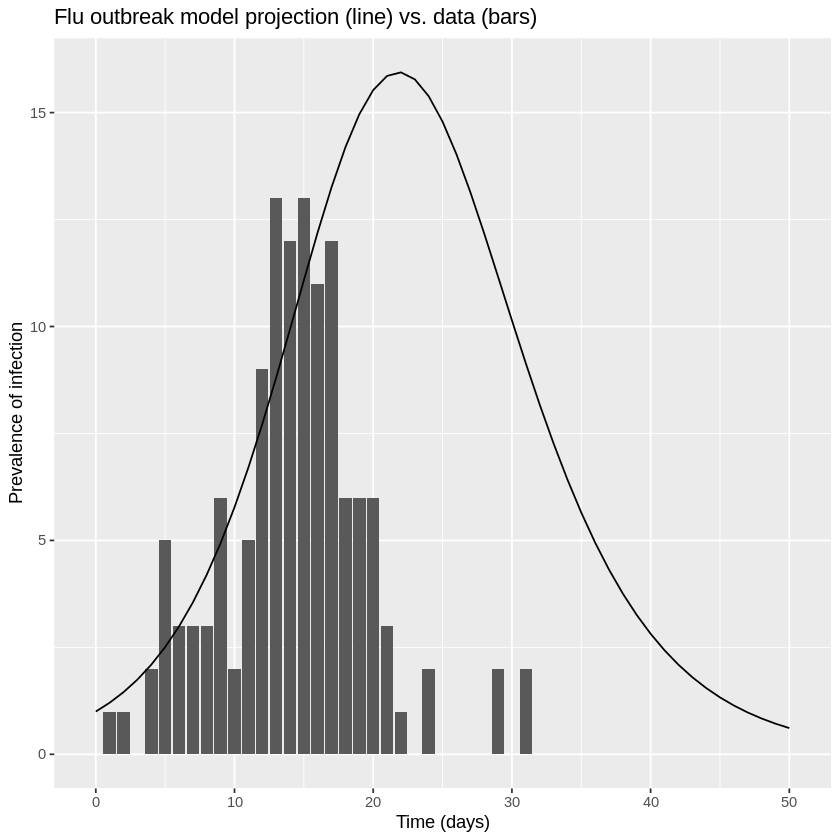

In [7]:
# Plot the model projection and the full dataset

ggplot() +
  geom_col(data = flu_data, aes(x = time, y = number_reported)) +  
  geom_line(data = output, aes(x = time, y = I)) +                              
  xlab("Time (days)")+                                              
  ylab("Prevalence of infection") +                                 
  labs(title = "Flu outbreak model projection (line) vs. data (bars)")

The plot shows that our calibrated parameter values give a good fit to the outbreak data before the school was closed. Comparing the model projection after day 17 with the datapoints suggests that the school closure had an effect on reducing the prevalence of infection: while the simulated prevalence keeps increasing after day 17, in reality (with the intervention) the peak of the epidemic had already been reached at that time.

### How many flu cases were averted by the school closure?

In [9]:
# Calculate the total number of cases after day 17 with/without the intervention
print("Number of cases with intervention (data):")
sum(flu_data$number_reported[flu_data$time>17])

print("Number of cases without intervention (model):")
sum(output$I[output$time>17])

# Calculate difference
print("Difference:")
sum(output$I[output$time>17])-sum(flu_data$number_reported[flu_data$time>17])

[1] "Number of cases with intervention (data):"


[1] 28

[1] "Number of cases without intervention (model):"


[1] 252.3393

[1] "Difference:"


[1] 224.3393

The model suggests that the school closure averted 224 flu cases.

**Dataset reference:**

Cauchemez, S., Bhattarai, A., Marchbanks, T. L., Fagan, R. P., Ostroff, S., Ferguson, N. M., & Pennsylvania H1N1 Working Group. (2011). Role of social networks in shaping disease transmission during a community outbreak of 2009 H1N1 pandemic influenza. Proceedings of the National Academy of Sciences, 108(7), 2825-2830.